# Proyecto: Predicción de los precios de automóviles

Supongamos que tenemos un sitio web donde las personas pueden comprar y vender autos usados. Cuando llega el momento de ofrecer sus vehículos, los vendedores a menudo lidian con el problema de establecer un precio razonable. Queremos ayudar a nuestros usuarios con un sistema recomendador de precios automático.

<center>
    <figure>
    <img src = "https://www.cars.com/images/sell/sale-dealer-woman.jpg" alt="Proyecto de un sistema automático de recomendación de precios de automóviles usados" style="width:500px;height:350px;">
    <figcaption> ¿Cómo sugerir un precio adecuado para los automóviles de nuestros usuarios? </figcaption>
    </figure>
</center>

Para ello, le pedimos a los vendedores que especifiquen el modelo, la marca, el año, el kilometraje y otras características importantes de un auto. Con base en dicha información, debemos sugerirles un precioo.

Afortunadamente, contamos con un conjunto de datos que contiene las características importantes que consideraremos. El plan del proyecto es el siguiente:

 1. Descargar el dataset.
 2. Hacer un análisis preliminar de los datos.
 3. Establecer una estrategia de validación para garantizar que el modelo genera predicciones correctas.
 4. Implementar un modelo de regresión.
 5. Hacer un poco de feature engineering para extraer características importantes de los datos para mejorar el modelo.
 6. Hacer nuestro modelo estable con regularización y utilizarlo para predecir precios de autos.

 ## Obteniendo los datos

 En este caso en particular, se obtuvo el conjunto de datos [Car Features and MSRP](https://www.kaggle.com/datasets/CooperUnion/cardataset?resource=download) de [Kaggle](https://www.kaggle.com/). El archivo se incluye en la carpeta `data` del repositorio.

## Análisis exploratorio de datos

Para cualquier tarea de machine learning, entender los datos es un paso fundamental. Antes de entrenar cualquier modelo, necesitamos saber qué tipo de datos tenemos y si nos serán útiles. De manera general, buscamos en el conjunto de datos:

 - La distribución de la variable objetivo.
 - Las características del conjunto de datos.
 - La distribución de los valores en estas características.
 - La calidad de los datos.
 - El número de valores faltantes.

 Las bibliotecas que utilizaremos en este proyecto son `NumPy`, `Pandas`, `Plotly` y `Seaborn`

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Importamos los datos

In [2]:
data = pd.read_csv('data/data.csv')

Verificamos el número de filas en la tabla

In [3]:
len(data)

11914

Tenemos cerca de 12,000 registros de autos en este dataset. Veamos las primeras filas del conjunto de datos.

In [5]:
data.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


A partir de esta primera inspección visual, podemos notar que existen algunas inconsistencias en los datos. Los nombres de las columnas tienen espacios y guiones bajos. También, algunos de los valores de las características están en mayúsculas, etc. 

Esto resulta inconveniente y puede llegar a ser confuso para nuestros propósitos. Así que debemos normalizar los datos, de preferencia, reemplazar los espacios con guiones bajos y poner todas las letras en minúsculas.

In [6]:
data.columns = data.columns.str.lower().str.replace(' ', '_')

In [7]:
string_columns = list(data.dtypes[data.dtypes == 'object'].index)

In [8]:
for col in string_columns:
    data[col] = data[col].str.lower().str.replace(' ', '_')

Después de estos cambios, veamos si el conjunto de datos se ve más uniforme:

In [9]:
data.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,bmw,1_series_m,2011,premium_unleaded_(required),335.0,6.0,manual,rear_wheel_drive,2.0,"factory_tuner,luxury,high-performance",compact,coupe,26,19,3916,46135
1,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,convertible,28,19,3916,40650
2,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,high-performance",compact,coupe,28,20,3916,36350
3,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,coupe,28,18,3916,29450
4,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,luxury,compact,convertible,28,18,3916,34500


Muy bien, continuemos con nuestro proyecto. Ahora que hemos normalizado nuestros valores string, prestamos atención al contenido de las columnas.

 - `make`: representa la marca del auto (BMW, Toyota, etc.).
 - `model`: es el modelo del auto.
 - `year`: el año en el que el auto fue manufacturado.
 - `engine_fuel_type`: tipo de combustible que el motor utiliza.
 - `engine_hp`: potencia del motor en caballos de fuerza (HP).
 - `engine_cylinders`: número de cilindros del motor.
 - `transmission_type`: tipo de transmisión del auto (manual o automática).
 - `driven_wheels`: tipo de tracción (delantera, trasera o completa).
 - `number_of_doors`: número de puertas.
 - `market_category`: tipo de mercado del auto (lujo, alto rendimiento, etc).
 - `vehicle_size`: tamaño del auto.
 - `vehicle_style`: estilo del vehículo (sedán o convertible).
 - `highway_mpg`: cantidad de millas recorridas por galón (mpg) en carretera.
 - `city_mpy`: cantidad de millas recorridas por galón en ciudad.
 - `popularity`: popularidad del auto respecto al número de veces que el auto fue mencionado en el stream de Twitter.
 - `msrp`: precio sugerido por el fabricante en dólares (manufacturer's suggested retail price).

En nuestro caso, la columna más interesante es la última, `msrp`, la cual en esencia contiene información acerca del precio del auto. La utilizaremos para predecir el precio de un auto.

Uno de los primeros pasos de un análisis exploratorio de datos es el ver cómo se comportan los valores de la variable que deseamos predecir. Generalmente lo logramos a través de una inspección visual de su distribución. Podemos utilizar entonces un histograma para ver esta distribución.

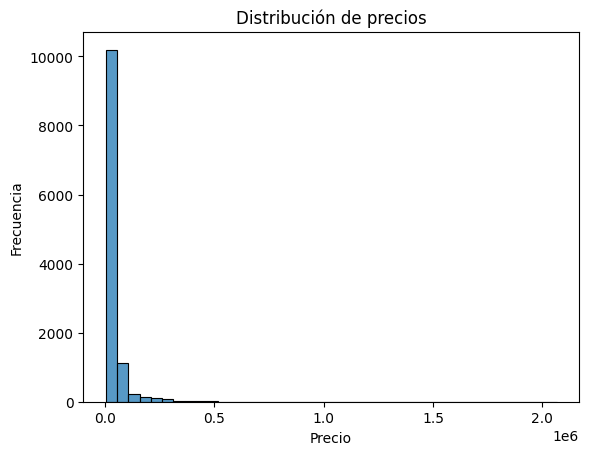

In [23]:
sns.histplot(data.msrp, bins = 40)
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.title('Distribución de precios')
plt.show()

Observamos de inmediato que la distribución de los precios muestra que existe una gran cantidad de autos de bajo precio y muy pocos con un valor alto. Hagamos un zoom tomando sólo los autos que cuesten menos de $100,000 USD.

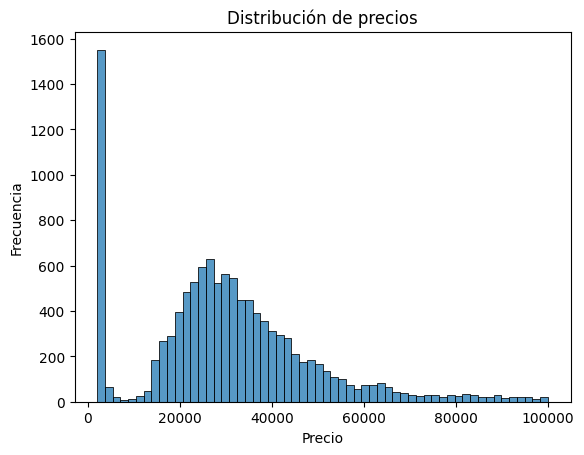

In [24]:
sns.histplot(data.msrp[data.msrp < 100000])
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.title('Distribución de precios')
plt.show()

Esta cola a la izquierda nos dificulta ver la distribución, pero más aún, puede llegar a confundir a los resultados del modelo, de tal forma que no aprenderá lo suficiente. 

Una forma sencilla de resolver este problema es utilizando una *transformación logarítmica*.

$$y_{\text{nuevo}} = \log (y + 1)$$

In [17]:
log_price = np.log1p(data['msrp'])

Veamos la nueva distribución de los datos logarítmicos.

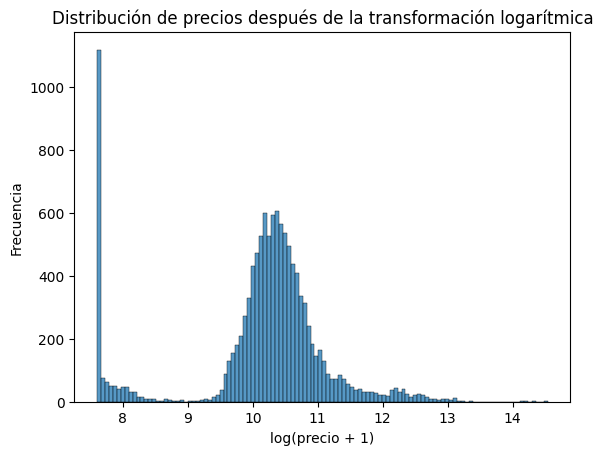

In [25]:
sns.histplot(log_price)
plt.xlabel('log(precio + 1)')
plt.ylabel('Frecuencia')
plt.title('Distribución de precios después de la transformación logarítmica')
plt.show()

Ahora sí, podemos observar que la distribución de los precios se asemeja a una campana. La distribución no es *normal*, debido a la presencia de la cola larga a en los precios más bajos, sin embargo el modelo puede lidiar con ello más fácilmente.

Ahora pasamos a otro punto importante en nuestro análisis exploratorio: buscar valores faltantes. Esto es necesario ya que ningún modelo de machine learning puede lidiar con valores nulos de manera automática. Debemos saber si necesitamos hacer algo especial para manejar dichos valores. 

Verificamos entonces si hay valores nulos en el dataset.

In [26]:
data.isnull().sum()

make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
dtype: int64

La buena noticia es que la columna `msrp` no tiene valores nulos. Podemos apreciar que la columna `market_category` tiene alrededor de 4000 datos faltantes. Más adelante veremos qué podemos hacer con estos datos.

## Validación

El siguiente paso es el establecer una estrategia de validación para garantizar que los modelos que entrenemos sean buenos y puedan generalizar. Es decir que el modelo pueda ser aplicado a nuevos datos nunca antes vistos por él. 

Para ello, utilizamos la *validación*. Necesitamos dividir al conjunto de datos en tres partes: *entrenamiento*, *validación* y *test*. Dividiremos los datos de la siguiente manera:

 - 20% de los datos serán para la validación.
 - 20% de los datos serán para el test.
 - 60% de los datos serán para el entrenamiento.



In [27]:
n = len(data) # número de columnas del dataframe

# Calculamos el número de datos a utilizar en cada etapa

n_val = int(0.2 * n)

n_test = int(0.2 * n)

n_train = n - (n_val + n_test)

In [28]:
print(f"Número de datos totales: {n}")
print(f"Número de datos para entrenamiento: {n_train}")
print(f"Número de datos para validación: {n_val}")
print(f"Número de datos para test: {n_test}")

Número de datos totales: 11914
Número de datos para entrenamiento: 7150
Número de datos para validación: 2382
Número de datos para test: 2382


Adicionalmente, vamos a mezclar el orden de los datos del dataframe:

In [30]:
np.random.seed(42) # Garantizamos reproducibilidad en nuestro proyecto

idx = np.arange(n) # Cramos un array de NumPy con los índices de la dataframe

np.random.shuffle(idx) # Lo revolvemos

data_shuffled = data.iloc[idx]

data_shuffled

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
3995,gmc,envoy_xl,2005,regular_unleaded,275.0,6.0,automatic,rear_wheel_drive,4.0,NaN,large,4dr_suv,18,13,549,29695
7474,volkswagen,passat,2016,regular_unleaded,170.0,4.0,automatic,front_wheel_drive,4.0,NaN,midsize,sedan,38,25,873,30495
7300,honda,odyssey,2016,regular_unleaded,248.0,6.0,automatic,front_wheel_drive,4.0,NaN,large,passenger_minivan,28,19,2202,37650
3148,chevrolet,cruze,2015,regular_unleaded,138.0,4.0,manual,front_wheel_drive,4.0,NaN,midsize,sedan,36,25,1385,16170
747,volvo,740,1991,regular_unleaded,162.0,4.0,automatic,rear_wheel_drive,4.0,"luxury,performance",midsize,sedan,20,17,870,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,toyota,venza,2014,regular_unleaded,181.0,4.0,automatic,front_wheel_drive,4.0,crossover,midsize,wagon,26,20,2031,27950
5191,pontiac,g6,2009,flex-fuel_(unleaded/e85),219.0,6.0,automatic,front_wheel_drive,4.0,flex_fuel,midsize,sedan,26,17,210,24710
5390,volkswagen,golf_gti,2016,premium_unleaded_(recommended),220.0,4.0,automated_manual,front_wheel_drive,2.0,"hatchback,performance",compact,2dr_hatchback,33,25,873,27590
860,saab,9-5,2009,premium_unleaded_(recommended),260.0,4.0,automatic,front_wheel_drive,4.0,"luxury,performance",midsize,wagon,27,17,376,43270


Dividimos el dataframe mezclado en los conjuntos de validación, test y entrenamiento.

In [31]:
data_train = data_shuffled.iloc[:n_train].copy()

data_val = data_shuffled.iloc[n_train:n_train + n_val].copy()

data_test = data_shuffled.iloc[n_train + n_val:].copy()

Ahora que el dataframe está dividido en tres partes, recordamos que nuestro análisis inicial sugirió aplicar una transformación logarítmica para deshacernos de la cola en la distribución de los precios, por lo que es conveniente aplicarla.

In [32]:
y_train = np.log1p(data_train.msrp.values)

y_val = np.log1p(data_val.msrp.values)

y_test = np.log1p(data_test.msrp.values)

Adicionalmente, para evitar utilizar la variable objetivo durante el entrenamiento del modelo, podemos remover la columna del dataframe.

In [33]:
del data_train['msrp']
del data_val['msrp']
del data_test['msrp']

## Machine Learning en problemas de regresión

Una vez que hemos hecho el análisis exploratorio de los datos y definido la estrategia de validación, estamos listos para entrenar un modelo. El problema que intentamos resolver es un *problema de regresión*: el objetivo es predecir un número, el precio de un auto. 

Por simplicidad, utilizaremos el modelo de regresión más simple: *regresión lineal*. 

Repasemos brevemente la idea detrás de la regresión lineal. De manera general, un modelo de machine learning supervisado tiene la forma:

$$ y \approx g(X) $$

donde $y$ es el vector de los valores que queremos predecir y $X$ es una matriz que contiene a las características de las observaciones. 

Para un solo registro, $y_i$ tenemos la relación $y_i \approx g(x_i)$. Si tenemos $n$ características, nuestro vector $x_i$ es $n$-dimensional, así que tiene $n$ componentes:

$$ x_i = (x_{i1}, x_{i2}, ..., x_{in})$$

Entonces, podemos escribir:

$$ y_i = g(x_i) = g(x_{i1}, x_{i2}, ..., x_{in})$$

En nuestro caso, tenemos 7150 autos en el conjunto de entrenamiento, $n = 7150$. Supongamos que $i=10$, tenemos el auto:

In [34]:
data_train.iloc[10]

make                            toyota
model                            yaris
year                              2015
engine_fuel_type      regular_unleaded
engine_hp                        106.0
engine_cylinders                   4.0
transmission_type               manual
driven_wheels        front_wheel_drive
number_of_doors                    2.0
market_category              hatchback
vehicle_size                   compact
vehicle_style            2dr_hatchback
highway_mpg                         37
city_mpg                            30
popularity                        2031
Name: 11815, dtype: object

Para mostrar la idea detrás de la regresión, escogemos algunas características numéricas e ignoramos el resto. Utilicemos `engine_hp`, `highway_mpg` y `popularity`.

Asignamos estas características como $x_{i1}$, $x_{i2}$ y $x_{i3}$, respectivamente:

$$ x_i = (x_{i1}, x_{i2}, x_{i3}) = (106, 37, 2031) $$

La idea es que al aplicar la función $g$ al vector $x_i$ el resultado sea lo más cercano posible al valor en la columna `msrp` para este auto.

Si $g$ es un modelo de regresión lineal, entonces tiene la siguiente forma general:

$$ g(x_i) = w_0 + x_{i1} w_1 + x_{i2} w_2 + \dots + x_{in} w_n $$

Las variables $w_0, w_1, w_2, ..., w_n$ son los parámetros del modelo. 

 - $w_0$ es el término umbral
 - $w_i$ son los *pesos* de cada característica $x_{in}$

Estos parámetros definen exactamente cómo el modelo debe combinar las características para que las predicciones al final sean tan cercanas al valor real como sea posible. 

En notación más compacta, tenemos:

$$ g(x_i) = w_0 + \sum_{j=1}^n x_{ij} w_j $$

Los valores de los pesos son lo que el modelo aprende cuando es entrenado. Pero, ¿cómo los obtenemos?

## Entrenamiento

El vector de pesos $w$ puede calcularse con la siguiente fórmula: 

$$ w = (X^T X)^{-1} X^T y $$

donde:

 - $X^T$ es la matriz transpuesta de $X$
 - $X^{-1}$ es la matriz inversa de $X$

Implementamos esta fórmula en NumPy:

In [36]:
def linear_regression(X, y):

    ones = np.ones(X.shape[0])

    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)

    XTX_inv = np.linalg.inv(XTX)

    w = XTX_inv.dot(X.T).dot(y)

    return w[0], w[1:]

Para poder utilizar este código necesitamos una matriz $X$ de características y un vector $y$ de la variable objetivo. Vamos a construir la matriz de características a partir de los datos de la dataframe. 

Comenzaremos con una forma sencilla: seleccionamos algunas características numéricas de la dataframe y con ellas creamos la matriz $X$. En el ejemplo anterior utilizamos sólo algunos, pero ahora utilizaremos:

 - `engine_hp`, `engine_cylinders`, `highway_mpg`, `city_mpg`, y `popularity`.

In [37]:
features = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg', 'popularity']

data_num = data_train[features]

In [38]:
data_num.head()

,engine_hp,engine_cylinders,highway_mpg,city_mpg,popularity
3995,275.0,6.0,18,13,549
7474,170.0,4.0,38,25,873
7300,248.0,6.0,28,19,2202
3148,138.0,4.0,36,25,1385
747,162.0,4.0,20,17,870


Recordemos que algunas de estas columnas contienen valores nulos. 